# Usage of multinmrfit package

### Prepare environment

- Download and install Anaconda (>= 3.7) on your computer: https://www.anaconda.com/distribution/
- Install `multinmrfit`:
  - run "Anaconda prompt" from the start menu
  - install cobrapy with: `pip install multinmrfit`
- Start Jupyter from the start menu
- Open the jupyter notbook

Initialize logger.

In [ ]:
import logging
import sys

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.DEBUG, stream=sys.stdout)

Load multinmrfit.

In [27]:
import multinmrfit.base.spectrum as spectrum
import multinmrfit.base.io as io

Load pandas to read data.

import pandas as pd

## Load models.

Load models of signals implemented in multinmrfit.

In [43]:
available_models = io.IoHandler.get_models()

2023-01-09 09:29:41,357 | DEBUG : add model from file 'model_doublet.py'
2023-01-09 09:29:41,359 | DEBUG : model name: doublet
2023-01-09 09:29:41,360 | DEBUG : add model from file 'model_singlet.py'
2023-01-09 09:29:41,361 | DEBUG : model name: singlet
2023-01-09 09:29:41,362 | DEBUG : add model from file 'model_triplet.py'
2023-01-09 09:29:41,364 | DEBUG : model name: triplet


## Load NMR data.

Data can be loaded from a TSV file.

In [29]:
test_synthetic_dataset = pd.read_table("./data/data_sim_nmrfit.csv", sep="\t")

Data can also be loaded from TopSpin files by providing all information in a dictionnary.

In [49]:
test_topspin_dataset = {"data_path":"C:/Bruker/TopSpin4.0.7/data",
                        "dataset":"CFE_test",
                        "expno":"991",
                        "procno":"1",
                        "rowno":"3"}

The window of interest can be provided as a tuple containing lower and upper boundaries.

In [45]:
window = (-0.2, 0.2)

We can then load the data in a Spectrum object.

In [31]:

# create Spectrum object
sp = spectrum.Spectrum(data=test_synthetic_dataset, window=window)


2023-01-07 16:47:02,785 | DEBUG : create Spectrum object


To view the spectrum, use the plot() method with exp=True.

2023-01-09 09:36:52,906 | DEBUG : create plot


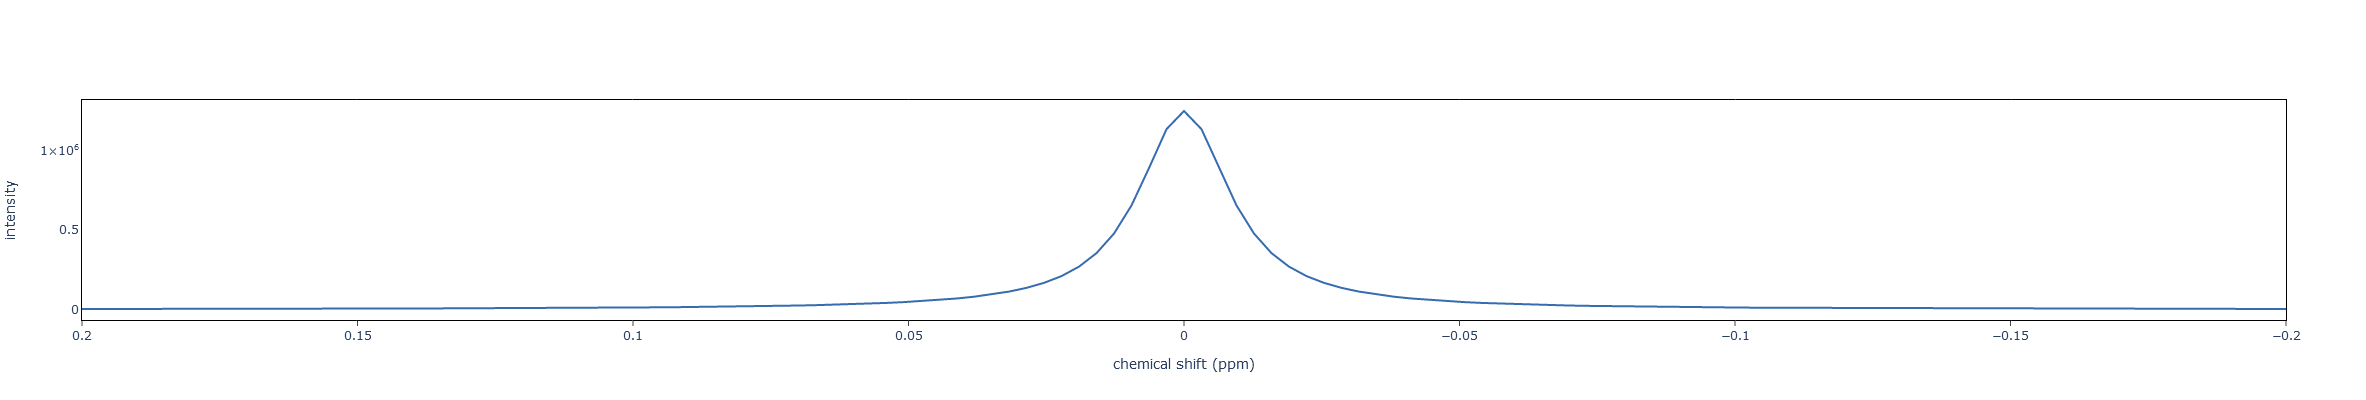

In [53]:
fig = sp.plot(exp=True)
fig.update_layout(autosize=False, width=900, height=400)
fig.show()

## Peak picking.

Use the peak_picking() method with the threshold provided as argument.

In [33]:
peak_table = sp.peak_picking(1e6)

2023-01-07 16:49:16,442 | DEBUG : peak peaking
2023-01-07 16:49:16,449 | DEBUG : peak table
      intensity  ppm  X_AXIS  cID  X_LW           VOL
0  1.250091e+06  0.0    63.0    1   2.0  3.521388e+06


To visualize the spectrum and the picked peaks, use the plot() method with the peak_table provided as argument pp.

2023-01-09 09:37:00,362 | DEBUG : create plot


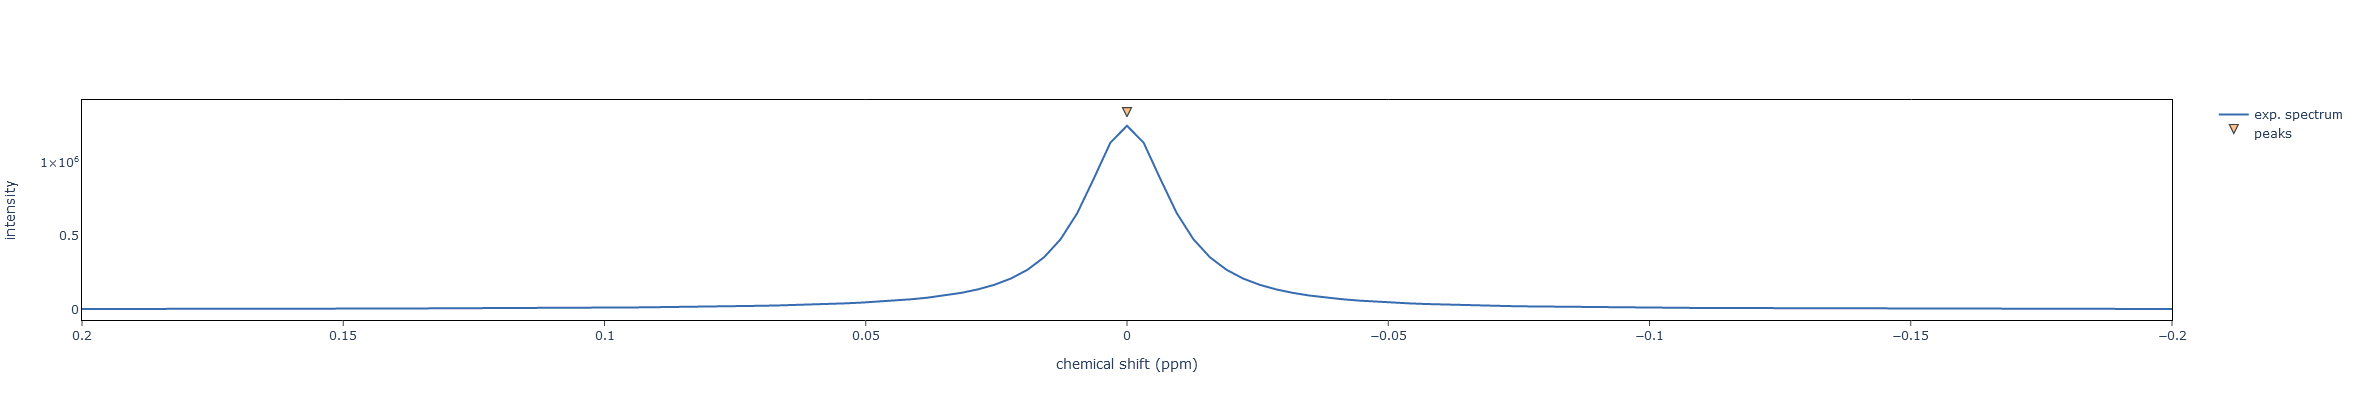

In [54]:
fig = sp.plot(pp=peak_table)
fig.update_layout(autosize=False, width=900, height=400)
fig.show()

## Spectrum simulation and fitting.

To simulate or fit a spectrum, we need to provide a list of signals containing the type of signal (e.g. singlet or doublet) and the corresponding parameters (chemical shift, coupling constant, linewidth, intensity, etc). Signals must be provided as a dictionary.

In [9]:

signals = {"singlet_TSP": {"model":"singlet", "par": {"x0": {"ini":0.0, "lb":-0.05, "ub":0.05}}}}

#signals = {"singlet_TSP": {"model":"singlet", "par": {"x0": {"ini":0.0, "lb":-0.05, "ub":0.05}}},
#           "doublet_TSP": {"model":"doublet", "par": {"x0": {"ini":-0.01, "lb":-0.01, "ub":0.01}, "J": {"ini":0.147, "lb":0.14, "ub":0.15}, "lw": {"ini":0.001}}}}


Then we can build a model of the spectrum.

In [35]:

# build model containing all signals
sp.build_model(signals=signals, available_models=available_models)


2023-01-07 16:49:26,084 | DEBUG : build Model for signal 'singlet_TSP'
2023-01-07 16:49:26,088 | DEBUG : parameters
     signal_id    model        par         ini     lb            ub
0  singlet_TSP  singlet         x0        1.00  0.000  1.000000e+01
1  singlet_TSP  singlet  intensity  1000000.00  1.000  1.000000e+15
2  singlet_TSP  singlet         lw        0.01  0.001  3.000000e-02
3  singlet_TSP  singlet         gl        0.50  0.000  1.000000e+00


We can update parameters and offser using the update_params() method.

In [ ]:
sp.update_params({"singlet_TSP": {"par": {"intensity": {"ini":1e6, "ub":1e12}}}})

Similarly, we can update the offset with the update_offset() method. If offset=None, the offset is removed. To set an offset, provide a dictionary (if empty, offset is initialized to default values).

In [36]:
sp.update_offset(offset={})

       signal_id    model        par         ini             lb            ub
0    singlet_TSP  singlet         x0        0.00      -0.050000  5.000000e-02
1    singlet_TSP  singlet  intensity  1000000.00       1.000000  1.000000e+12
2    singlet_TSP  singlet         lw        0.01       0.001000  3.000000e-02
3    singlet_TSP  singlet         gl        0.50       0.000000  1.000000e+00
4  full_spectrum     None     offset        0.00 -250018.225728  2.500182e+05


Parameters can be accessed via the params attibute.

In [56]:
sp.params

,signal_id,model,par,ini,lb,ub,opt,opt_sd,integral
0,singlet_TSP,singlet,x0,0.00,-0.050000,5.000000e-02,2.104864e-09,0.000008,39268.206279
1,singlet_TSP,singlet,intensity,1000000.00,1.000000,1.000000e+12,1.250001e+06,1109.179365,39268.206279
2,singlet_TSP,singlet,lw,0.01,0.001000,3.000000e-02,9.999986e-03,0.000006,39268.206279
3,singlet_TSP,singlet,gl,0.50,0.000000,1.000000e+00,1.000000e+00,0.000088,39268.206279
4,full_spectrum,None,offset,0.00,-250018.225728,2.500182e+05,9.126999e+01,102.252934,NaN


To fit experimental spectrum, use the fit() method.

In [57]:
sp.fit()

2023-01-09 09:43:39,298 | DEBUG : fit spectrum
2023-01-09 09:43:39,921 | DEBUG : parameters
       signal_id    model        par         ini             lb            ub  \
0    singlet_TSP  singlet         x0        0.00      -0.050000  5.000000e-02   
1    singlet_TSP  singlet  intensity  1000000.00       1.000000  1.000000e+12   
2    singlet_TSP  singlet         lw        0.01       0.001000  3.000000e-02   
3    singlet_TSP  singlet         gl        0.50       0.000000  1.000000e+00   
4  full_spectrum     None     offset        0.00 -250018.225728  2.500182e+05   

            opt       opt_sd      integral  
0  2.104864e-09     0.000008  39268.206279  
1  1.250001e+06  1109.179365  39268.206279  
2  9.999986e-03     0.000006  39268.206279  
3  1.000000e+00     0.000088  39268.206279  
4  9.126999e+01   102.252934           NaN  


Estimated parameters, standard deviations and integrals are now in the params attributes.

In [13]:
# display estimated parameters
sp.params


,signal_id,model,par,ini,lb,ub,opt,opt_sd,integral
0,singlet_TSP,singlet,x0,0.00,-0.050000,5.000000e-02,2.104864e-09,0.000008,39268.206279
1,singlet_TSP,singlet,intensity,1000000.00,1.000000,1.000000e+12,1.250001e+06,1109.179365,39268.206279
2,singlet_TSP,singlet,lw,0.01,0.001000,3.000000e-02,9.999986e-03,0.000006,39268.206279
3,singlet_TSP,singlet,gl,0.50,0.000000,1.000000e+00,1.000000e+00,0.000088,39268.206279
4,full_spectrum,None,offset,0.00,-250018.225728,2.500182e+05,9.126999e+01,102.252934,NaN


Fitting results can be viewed using the plot method with fit=True.

2023-01-09 09:44:53,380 | DEBUG : create plot


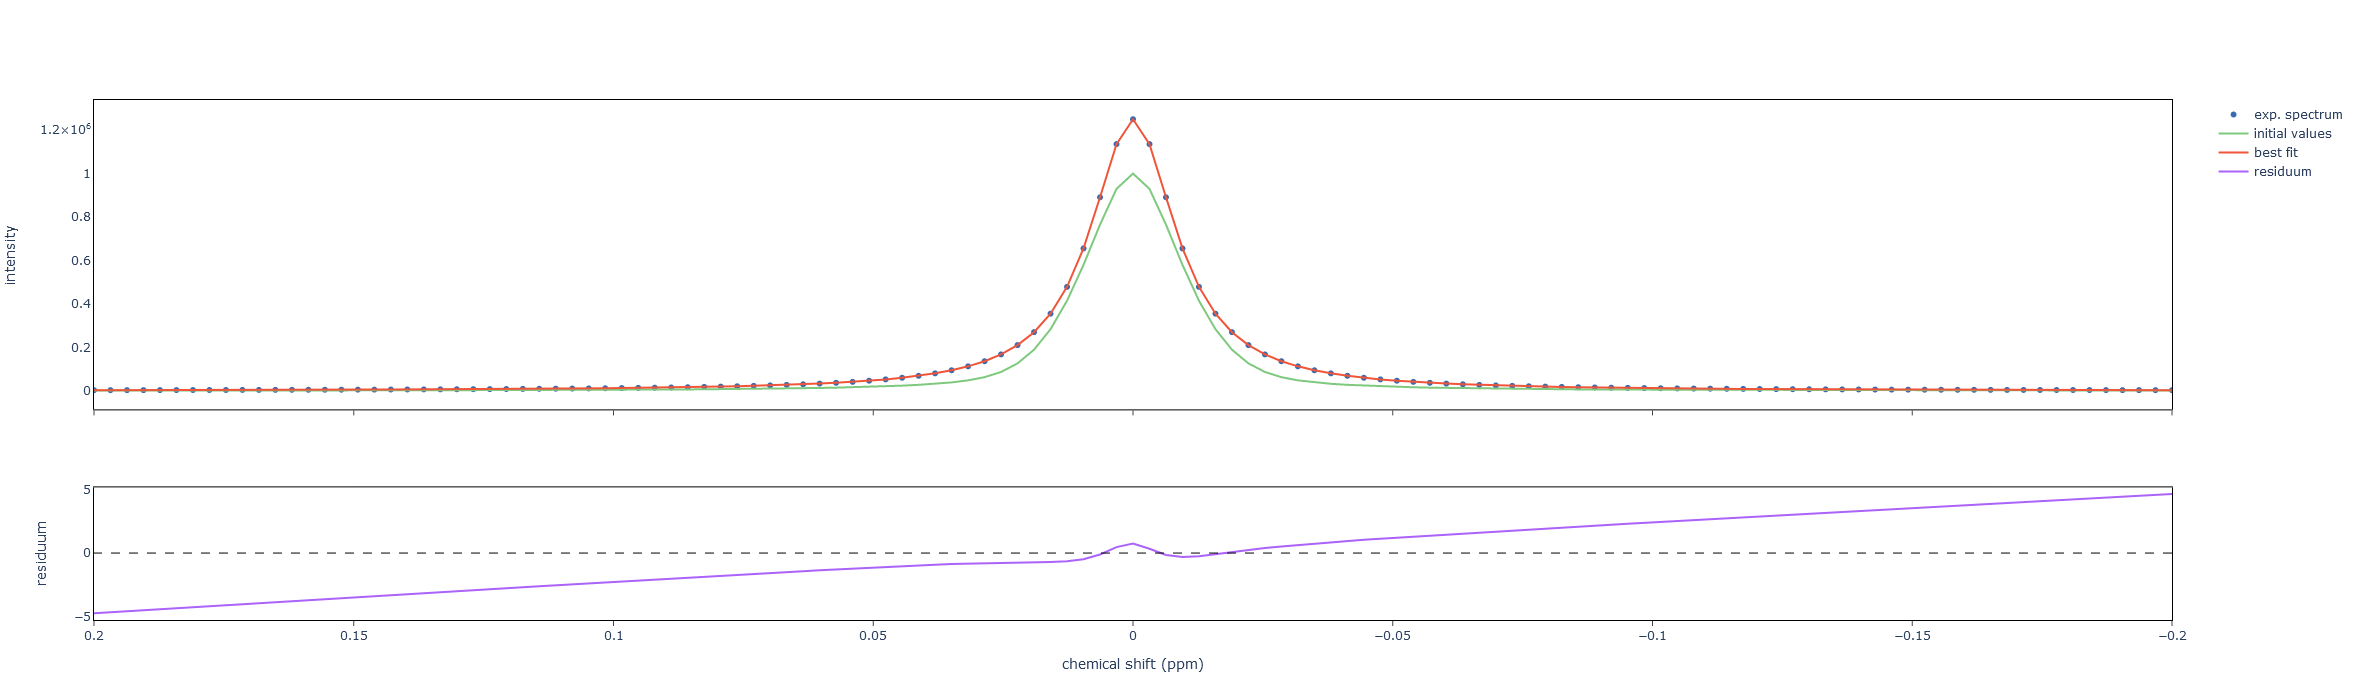

In [59]:
fig = sp.plot(ini=True, fit=True)
fig.update_layout(autosize=False, width=900, height=700)
fig.show()


Documentation of Spectrum object

        
Arguments

        data_path : str
            path of TopSpin data folder
        dataset : str
            dataset name
        expno : str
            expno
        procno : str
            procno
        rowno : str | None (optional, default=None)
            rowno (default: None)
#             note: assume 1D data if None, otherwise 2D data expected
#         window : tuple | None (optional, default=None)
#             lower and upper chemical shifts of the window of interest (in ppm)
#             provided as numeric, full spectrum if None
#        
#         Attributes
#         ----------
#         data_path : str
#             path of TopSpin data folder
#         dataset : str
#             dataset name
#         expno : str
#             expno
#         procno : str
#             procno
#         rowno : str
#             rowno
#         window : tuple | None
#             lower and upper chemical shifts of the window of interest (in ppm)
#             provided as numeric, full spectrum if None
#         ppm : list
#             experimental chemical shifts (in ppm), provided as numeric
#         intensity : str
#             chemical shifts (in ppm), provided as numeric
#         offset : bool
#             True if the spectrum model has an offset, otherwise False,
#             set by build_models()
#         models : dict
#             with signal names as key and the corresponding Model objects as values,
#             set by build_models()
#         params : pd.DataFrame
#             pandas DataFrame containing all parameters of the full spectrum,
#             set by build_models()
#         fit_results : object
#             OptimizeResult object returned by scipy.optimize.minimize, with an 
#             additional 'best_fit' attribute (a list of intensities for the best fit),
#             set by fit()
#        
#         Methods
#         -------
#         __init__(data_path: str, dataset: str, expno: str, procno: str, rowno: str | None, window: tuple | None, data: pd.DataFrame | None)
#             Initialize attributes and load NMR data (from data if not None, otherwise reads 
#             TopSpin files given in data_path, dataset, expno, procno, rowno).
#         peak_picking(threshold: numeric)
#             Performs peak picking using the threshold provided.
#             Returns the peak table as a pandas.DataFrame.
#         build_model(signals: dict, available_models: dict, offset: dict | None)
#             Build the complete model of the spectrum by initializing a model for each 
#             signal (in 'model' attribute), parameters (initial value and lower & upper 
#             bounds, in 'params' attribute) and offset (in 'offset' and 'params' attributes).
#         update_params(signals: dict)
#             Update the value (initial, lower and/or upper bound) of one or several parameters 
#             of one or several signals in 'params' attribute.
#         update_offset(offset: dict | None)
#             Update the value of the offset (in 'offset' and 'params' attributes). Offset is
#             removed is set to None.
#         simulate(params: dict | None)
#             Simulate spectrum. If params is None (default), initial values (in 'params' attribute) 
#             are used for simulation.
#             Returns a list of simulated intensities.
#         fit(method: str)
#             Fit experimental spectrum using the 'L-BFGS-B' (default) or 'differential_evolution' 
#             optimization methods & calculate integral of each signal, update 'params' and 
#             'fit_results' attributes.
#             Returns an OptimizeResult object generated by scipy.optimize.minimize.
#         integrate(params: dict | None, bounds: list)
#             Integrate each signal of the full spectrum over the range given in 'bounds' 
#             (default: [-100.0, 300.0]).
#             If params is None, initial values (in 'params' attribute) are used for simulation.
#             Returns integrals as a dict.
#         plot(exp: bool, ini: bool, fit: bool, pp: pd.DataFrame | None)
#             Plot the following data: experimental spectrum (exp, default: True), spectrum simulated from 
#             initial parameters values (see 'params' attribute) (ini, default: False), spectrum simulated 
#             for the best fit (fit, default: False), and peak picking results (pp, default: None).
#             Returns the figure as a pyplot.subplots.make_subplots object.
#         """

